<a href="https://colab.research.google.com/github/wnsdud3838/repo_zoon/blob/HW/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# visualize current GPU usages in your server
!nvidia-smi 

Tue Mar  2 01:28:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# set gpu by number 
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

In [ ]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio #### install with "pip install imageio"
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [ ]:
# visualize the first image from the torch tensor
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [ ]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid 
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('/gdrive/My Drive/img_align_celeba/img/training_progress.gif', training_progress_images)
    return training_progress_images

In [ ]:
# visualize gif file
def vis_gif(training_progress_images):
    fig = plt.figure()
    
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    html = ani.to_html5_video()
    HTML(html)

In [ ]:
# visualize gif file
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()
    
    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [ ]:
def save_image_list(dataset, real):
    if real:
        base_path = '/gdrive/My Drive/img_align_celeba/img/real'
    else:
        base_path = '/gdrive/My Drive/img_align_celeba/img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)
    
    return base_path

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2021-03-02 01:29:22--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.80
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  42.5MB/s    in 33s     

2021-03-02 01:29:55 (41.7 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
dataroot = './data_faces'
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2, drop_last=True)

In [ ]:
# Create folders
if not os.path.exists('/gdrive/My Drive/img_align_celeba/checkpoint'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/checkpoint')
    
if not os.path.exists('/gdrive/My Drive/img_align_celeba/dataset'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/dataset')
    
if not os.path.exists('/gdrive/My Drive/img_align_celeba/img'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/img')
    
if not os.path.exists('/gdrive/My Drive/img_align_celeba/img/real'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/img/real')

if not os.path.exists('/gdrive/My Drive/img_align_celeba/img/fake'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/img/fake')

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
nc = 3 # number of channels, RGB
nz = 100 # input noise dimension
ngf = 64 # number of generator filters
ndf = 64 #number of discriminator filters

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
netG = Generator().cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

netD = Discriminator().cuda()


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5,0.999))

In [ ]:
fixed_noise = torch.randn(128, nz, 1, 1).cuda()

criterion = nn.BCELoss()

n_epoch = 20
training_progress_images_list = []
for epoch in range(n_epoch):
    for i, (data, _) in enumerate(dataloader):
        ####################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###################################################
        # train with real
        netD.zero_grad()
        data = data.cuda()
        batch_size = data.size(0)
        label = torch.ones((batch_size,)).cuda() # real label = 1
        output = netD(data)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(128, nz, 1, 1).cuda()
        fake = netG(noise)
        label = torch.zeros((batch_size,)).cuda() # fake label = 0
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        
        # Loss backward
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        ########################################
        # (2) Update G network: maximize log(D(G(z))) #
        ########################################
        netG.zero_grad()
        label = torch.ones((batch_size,)).cuda()  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        errG.backward()
        optimizerG.step()
        
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
              % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    #save the output
    fake = netG(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, fake)  # Save fake image while training!
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), '/gdrive/My Drive/img_align_celeba/checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), '/gdrive/My Drive/img_align_celeba/checkpoint/netD_epoch_%d.pth' % (epoch))

[0/20] Loss_D: 0.2643 Loss_G: 3.7363 D(x): 0.8686 D(G(z)): 0.0955 / 0.0361
[1/20] Loss_D: 0.5849 Loss_G: 2.0002 D(x): 0.7176 D(G(z)): 0.1756 / 0.1665
[2/20] Loss_D: 2.0929 Loss_G: 0.9819 D(x): 0.1815 D(G(z)): 0.0151 / 0.4529
[3/20] Loss_D: 0.5056 Loss_G: 2.3941 D(x): 0.7629 D(G(z)): 0.1767 / 0.1156
[4/20] Loss_D: 0.7460 Loss_G: 3.0997 D(x): 0.8621 D(G(z)): 0.3986 / 0.0661
[5/20] Loss_D: 0.4264 Loss_G: 2.2810 D(x): 0.8182 D(G(z)): 0.1747 / 0.1409
[6/20] Loss_D: 0.7251 Loss_G: 1.5031 D(x): 0.5615 D(G(z)): 0.0421 / 0.2873
[7/20] Loss_D: 0.4647 Loss_G: 2.5528 D(x): 0.8344 D(G(z)): 0.2079 / 0.1072
[8/20] Loss_D: 0.7005 Loss_G: 1.4556 D(x): 0.6023 D(G(z)): 0.0771 / 0.3023
[9/20] Loss_D: 0.3492 Loss_G: 3.4854 D(x): 0.9163 D(G(z)): 0.2090 / 0.0428
[10/20] Loss_D: 0.8957 Loss_G: 2.2620 D(x): 0.5095 D(G(z)): 0.0264 / 0.1573
[11/20] Loss_D: 0.6008 Loss_G: 5.4861 D(x): 0.9605 D(G(z)): 0.3633 / 0.0085
[12/20] Loss_D: 0.1886 Loss_G: 3.6969 D(x): 0.9307 D(G(z)): 0.0949 / 0.0380
[13/20] Loss_D: 0.3946

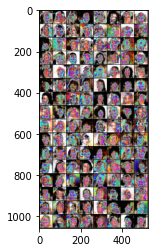

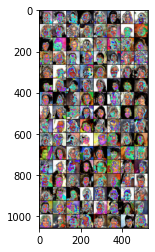

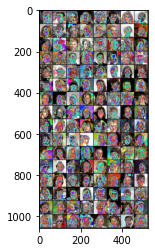

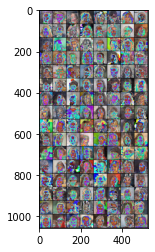

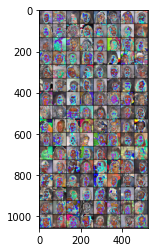

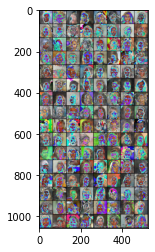

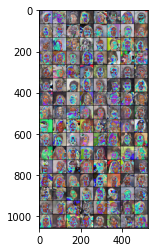

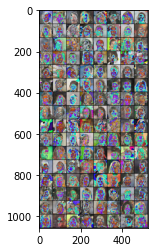

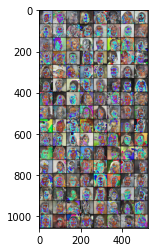

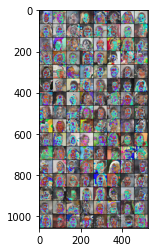

In [ ]:
#vis_gif(training_progress_images_list)
plot_gif(training_progress_images_list)

FID

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg' -O inception.py

--2021-03-02 03:13:13--  https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg
Resolving docs.google.com (docs.google.com)... 172.217.5.238, 2607:f8b0:4004:80a::200e
Connecting to docs.google.com (docs.google.com)|172.217.5.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rrrqtuf42avggeh8nm6cvemb7bgtah4t/1614654750000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download [following]
--2021-03-02 03:13:14--  https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rrrqtuf42avggeh8nm6cvemb7bgtah4t/1614654750000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download
Resolving doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-docs.googleusercontent.com)... 172.217.13.225, 2607:f8b0:4004:809::2001
Connecting to doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-docs.googleu

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y' -O fid_score.py

--2021-03-02 03:13:14--  https://docs.google.com/uc?export=download&id=1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y
Resolving docs.google.com (docs.google.com)... 172.217.5.238, 2607:f8b0:4004:805::200e
Connecting to docs.google.com (docs.google.com)|172.217.5.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7e840srpr7eaq0ft7ug1rjo7r6hb1au2/1614654750000/05323530314538631540/*/1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y?e=download [following]
--2021-03-02 03:13:14--  https://doc-08-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7e840srpr7eaq0ft7ug1rjo7r6hb1au2/1614654750000/05323530314538631540/*/1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y?e=download
Resolving doc-08-6s-docs.googleusercontent.com (doc-08-6s-docs.googleusercontent.com)... 172.217.13.225, 2607:f8b0:4004:809::2001
Connecting to doc-08-6s-docs.googleusercontent.com (doc-08-6s-docs.googleu

In [ ]:
from fid_score import calculate_fid_given_paths  # The code is downloaded from github

In [ ]:
dataroot = './data_faces'
test_dataset = dset.ImageFolder(root=dataroot, 
                              transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True, num_workers=2, drop_last=True)

for i, (data, _) in enumerate(dataloader):
    real_dataset = data
    break
    
noise = torch.randn(1000, 100, 1, 1).cuda()
fake_dataset = netG(noise)

In [ ]:
real_image_path_list = save_image_list(real_dataset, True)
fake_image_path_list = save_image_list(fake_dataset, False)

In [ ]:
# calculate_fid_given_paths(paths, batch_size, cuda, dims)
fid_value = calculate_fid_given_paths([real_image_path_list, fake_image_path_list],
                                                          100, 
                                                          True,
                                                          2048)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


In [ ]:
print (f'FID score: {fid_value}')

FID score: 35.32937578267362


In [ ]:
!tar -czvf 20204551.tar.gz /gdrive/"My Drive"/img_align_celeba/img/fake/ -C /gdrive/"My Drive"/img_align_celeba/

tar: Removing leading `/' from member names
/gdrive/My Drive/img_align_celeba/img/fake/
/gdrive/My Drive/img_align_celeba/img/fake/image_0.png
/gdrive/My Drive/img_align_celeba/img/fake/image_1.png
/gdrive/My Drive/img_align_celeba/img/fake/image_2.png
/gdrive/My Drive/img_align_celeba/img/fake/image_3.png
/gdrive/My Drive/img_align_celeba/img/fake/image_4.png
/gdrive/My Drive/img_align_celeba/img/fake/image_5.png
/gdrive/My Drive/img_align_celeba/img/fake/image_7.png
/gdrive/My Drive/img_align_celeba/img/fake/image_8.png
/gdrive/My Drive/img_align_celeba/img/fake/image_10.png
/gdrive/My Drive/img_align_celeba/img/fake/image_9.png
/gdrive/My Drive/img_align_celeba/img/fake/image_11.png
/gdrive/My Drive/img_align_celeba/img/fake/image_6.png
/gdrive/My Drive/img_align_celeba/img/fake/image_14.png
/gdrive/My Drive/img_align_celeba/img/fake/image_15.png
/gdrive/My Drive/img_align_celeba/img/fake/image_12.png
/gdrive/My Drive/img_align_celeba/img/fake/image_13.png
/gdrive/My Drive/img_align